In [1]:
# For inline plotting
%matplotlib inline

# For auto reloading
%load_ext autoreload
%autoreload 2

# MNIST dataset with MLP

[reference](https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.3.1  Device: cuda


## Data

Next we'll load the MNIST data. First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [3]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

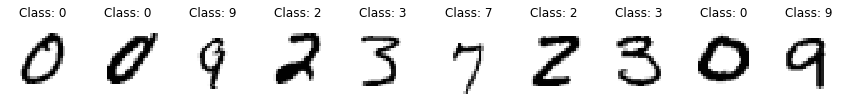

In [5]:
pltsize = 1.5
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('Class: {}'.format(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [6]:
import sys
sys.path.append('../bibd')
from bibd_layer import BibdLinear

r = 7

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, r*(r+1))
        self.fc1_drop = nn.Dropout(0.2)
        self.bibd2 = BibdLinear(r*(r+1), r*r, number_of_block=r)
        self.fc3 = nn.Linear(r*r, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.bibd2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=56, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (bibd2): BibdLinear()
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [7]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [8]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `validate()`. 

In [9]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325233
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.180618
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.920563
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.196113
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.901234
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.604946
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.506741
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.593116
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.465387
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.419238

Validation set: Average loss: 0.3852, Accuracy: 8932/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.304802
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.562604
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.445875
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.248973
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.443717
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.495356
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.423786
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.569024
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.17